# Spatial-temporal Toy problem
$f_t(\mathbf{u},\lambda) = \lambda_x(\vec{x} - 0.5)^2 - \lambda_y(\vec{y} - 0.5)^2$

$\mathbf{u} = \begin{bmatrix}\vec{x}\\\vec{y}\end{bmatrix}, \qquad \lambda(t) = \begin{bmatrix}\lambda_x(t)\\\lambda_y(t)\end{bmatrix} = \begin{bmatrix}2 + \sin(\omega t)\\ 2 - \sin(\omega t)\end{bmatrix}$

$y_t = f_t(\mathbf{u},\lambda(t)) + \nu_t,\qquad \nu_t\sim\mathcal{N}(0,\mathbf{Q}_t)$

In [ ]:
include("GP.jl")

sample_posterior (generic function with 1 method)

In [2]:
function fₜ(𝐮,λ)
    𝑥,𝑦 = 𝐮
    return λ[1]*(𝑥 - 0.5).^2 - λ[2]*(𝑦 - 0.5).^2
end

fₜ (generic function with 1 method)

In [ ]:
𝑛ₜ = 100
Δᵤ = 50
𝑛ᵤ = 25
ω  = 8π ;

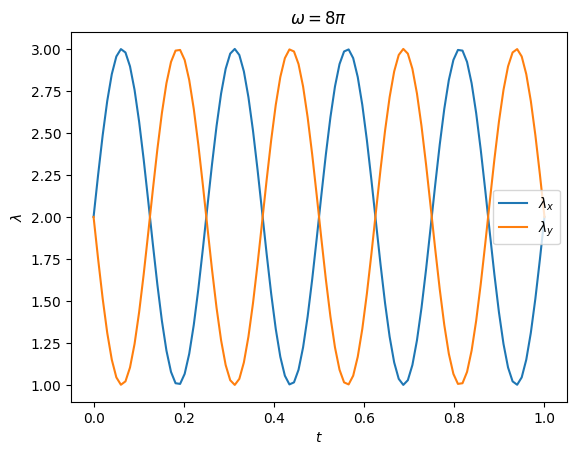

PyObject <matplotlib.text.Text object at 0x00000000281C7A20>

In [4]:
𝑡 = linspace(0,1,𝑛ₜ)


𝛌 = [2 + sin.(ω.*𝑡),
     2 - sin.(ω.*𝑡)]

using PyPlot
plot(𝑡, 𝛌[1],"-",
     𝑡, 𝛌[2],"-")

legend(labels=[L"$\lambda_x$",L"$\lambda_y$"])
xlabel(L"$t$"), ylabel(L"$\lambda$")
title(L"$\omega = 8\pi$")

In [5]:
𝐮 = (repmat(linspace(0.,1.,Δᵤ)',Δᵤ,1), repmat(linspace(0.,1.,Δᵤ),1,Δᵤ))

𝐐 = 0.1.^2

𝐟 = map(λ -> fₜ(𝐮,λ), zip(𝛌[1],𝛌[2]))
𝐲 = map(λ -> fₜ(𝐮,λ) + chol(𝐐)*randn((Δᵤ,Δᵤ)), zip(𝛌[1],𝛌[2]))

; # terminate output

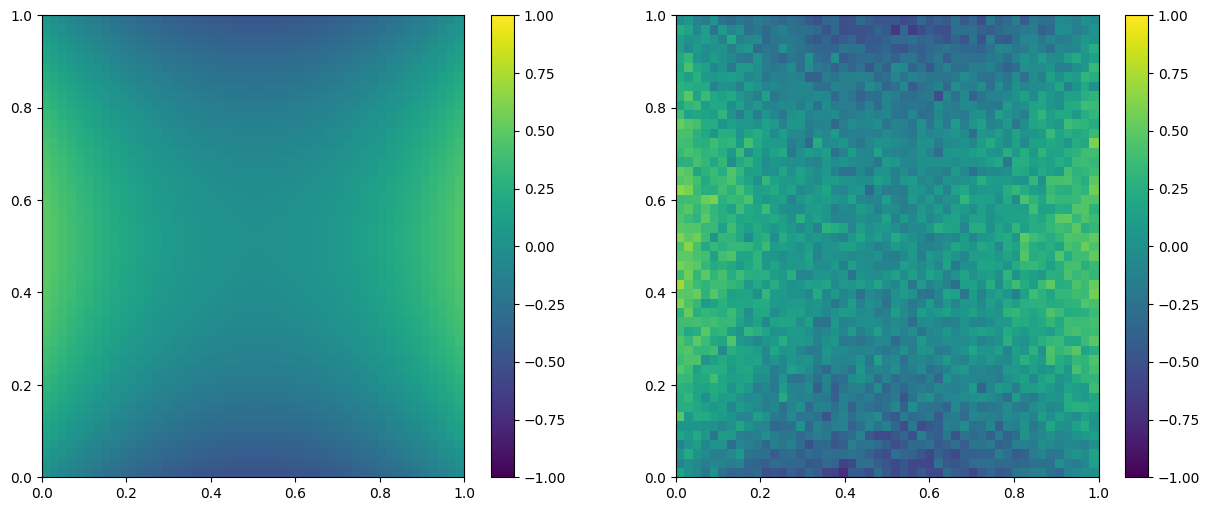

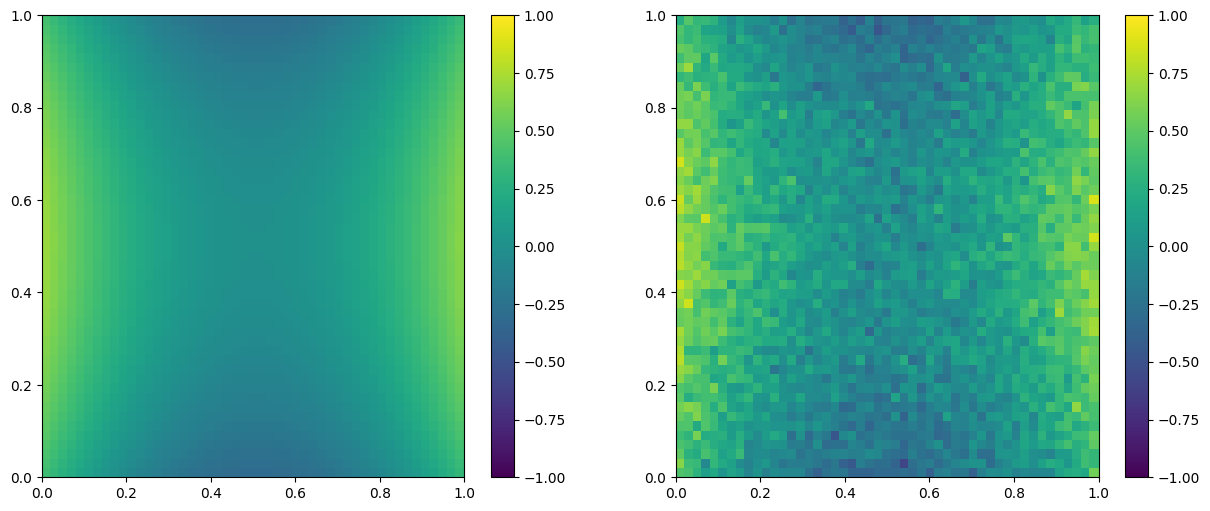

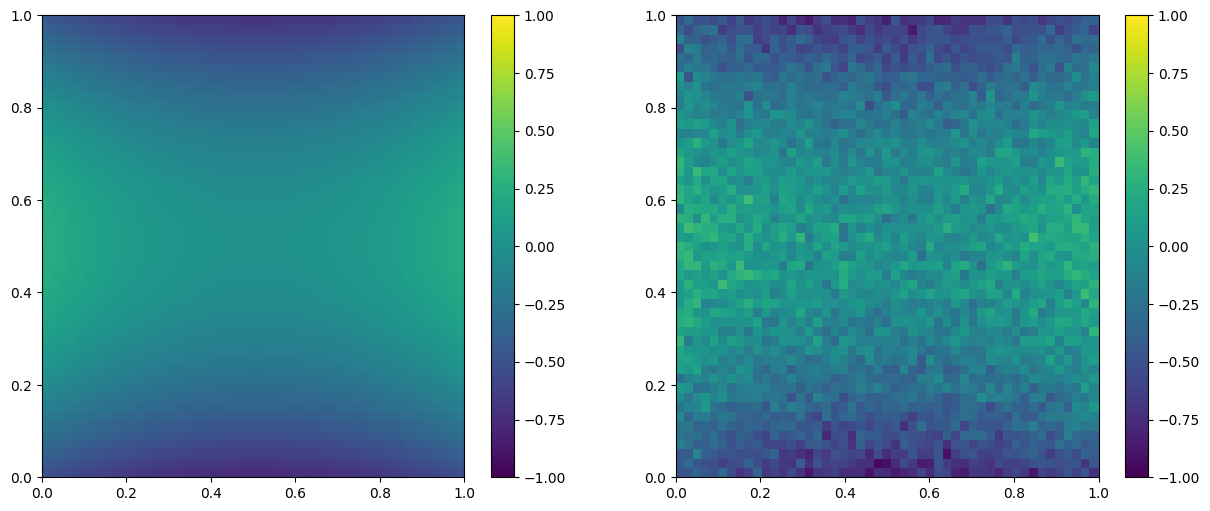

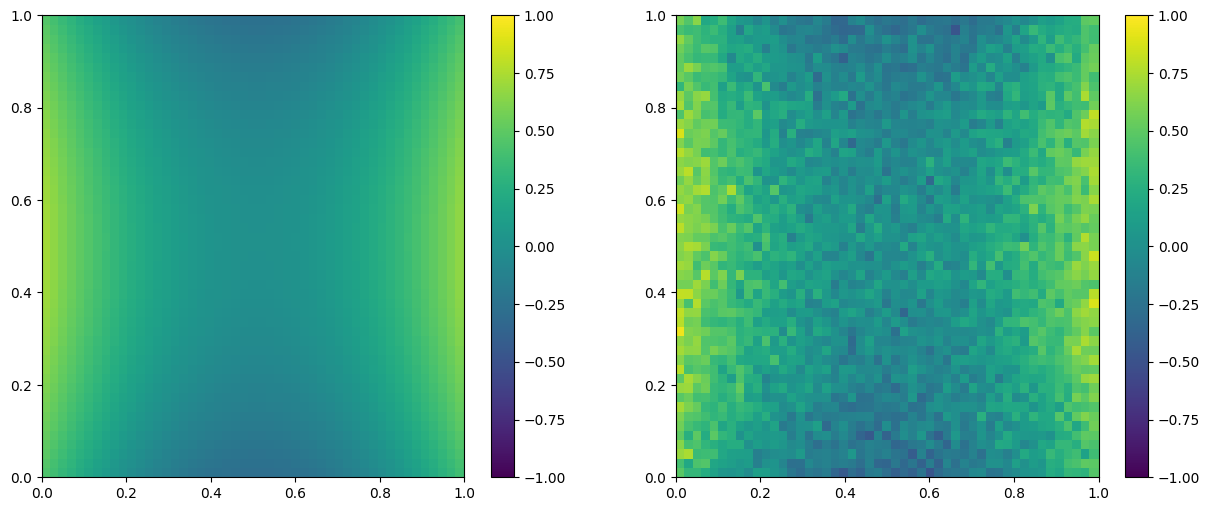

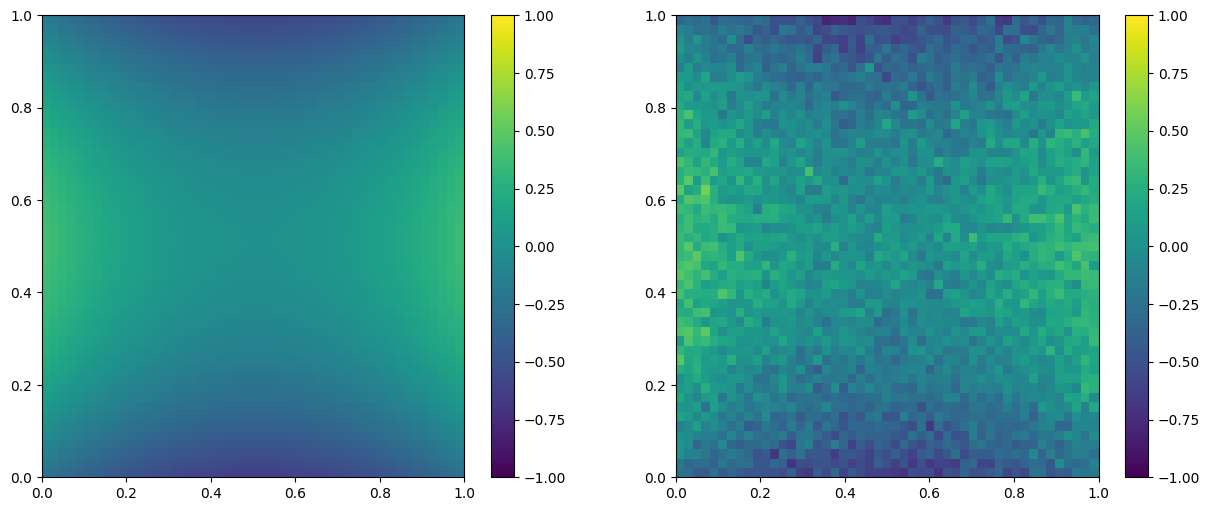

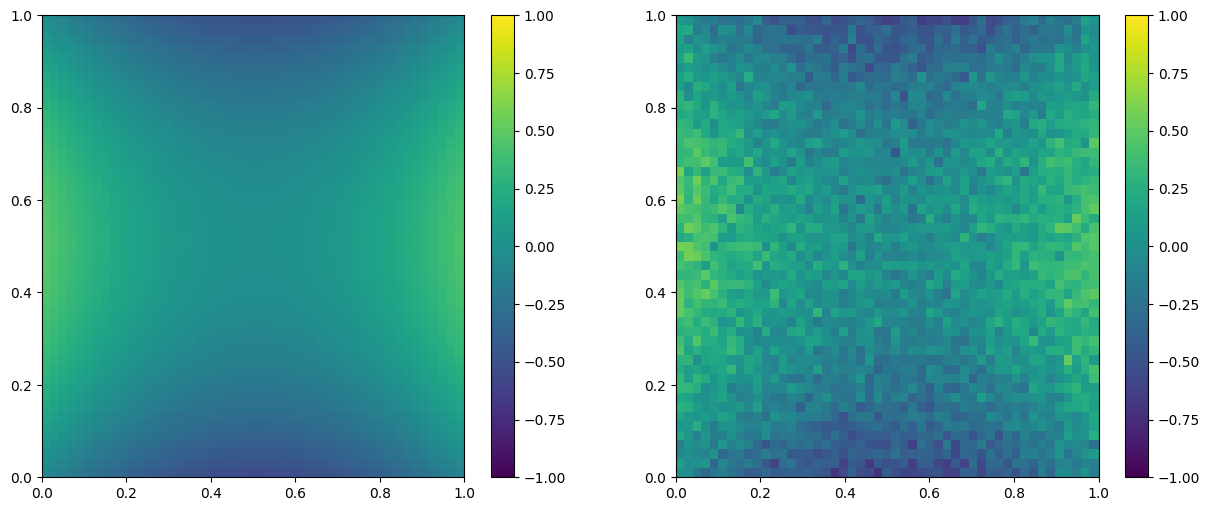

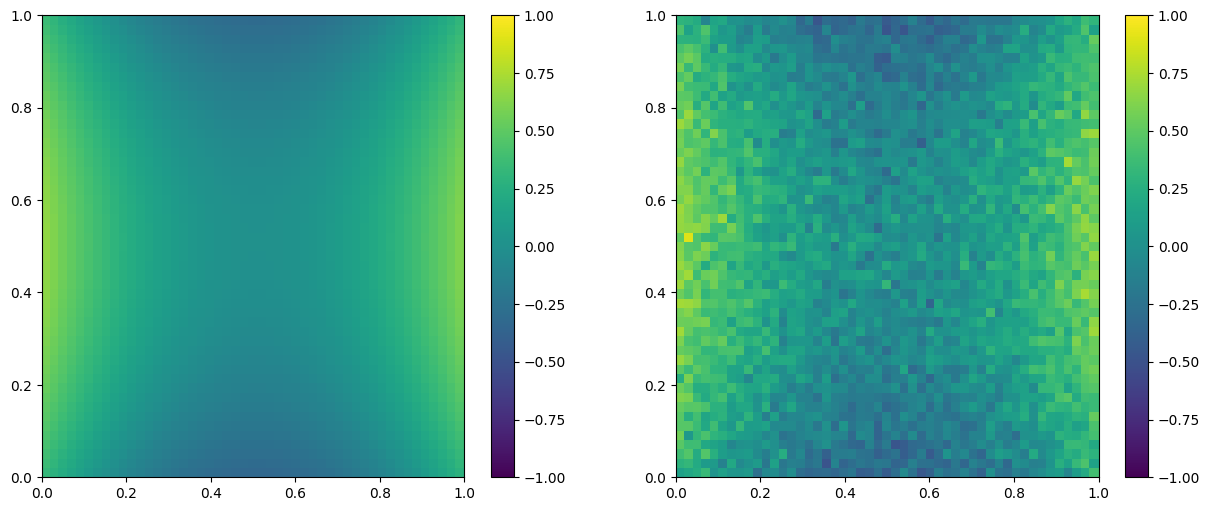

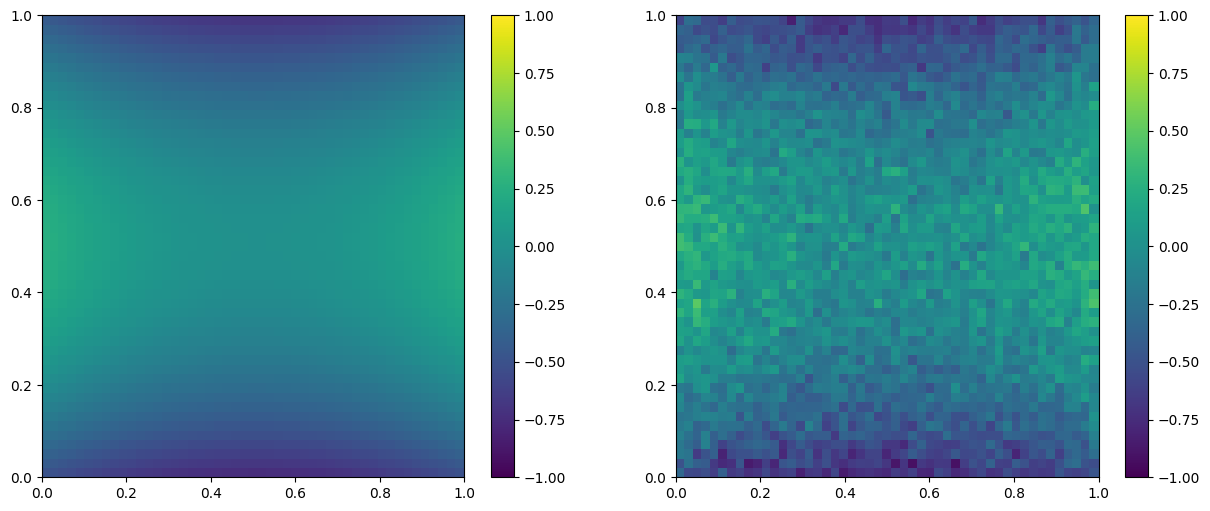

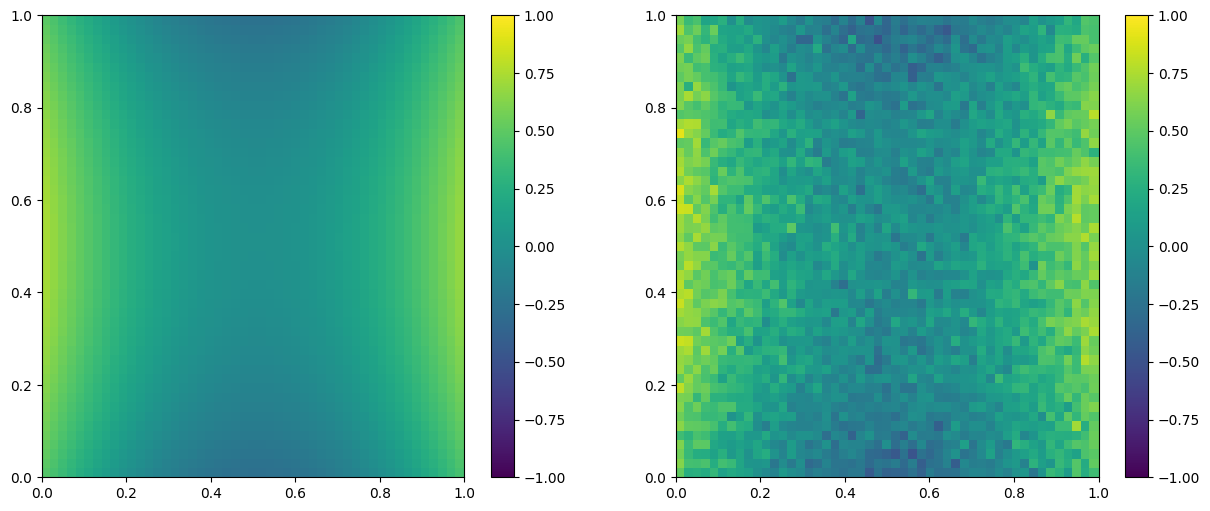

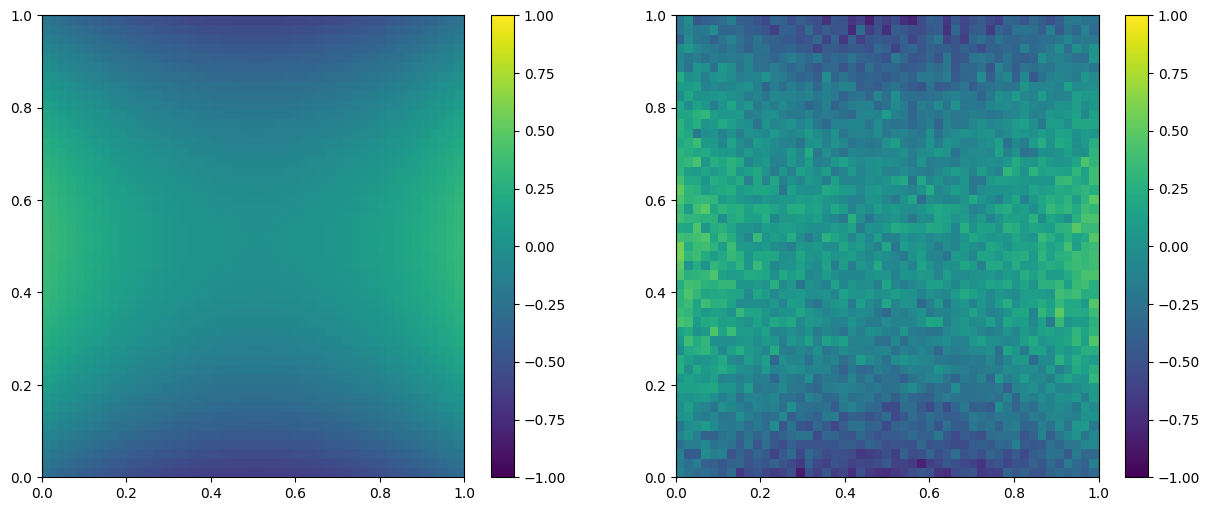

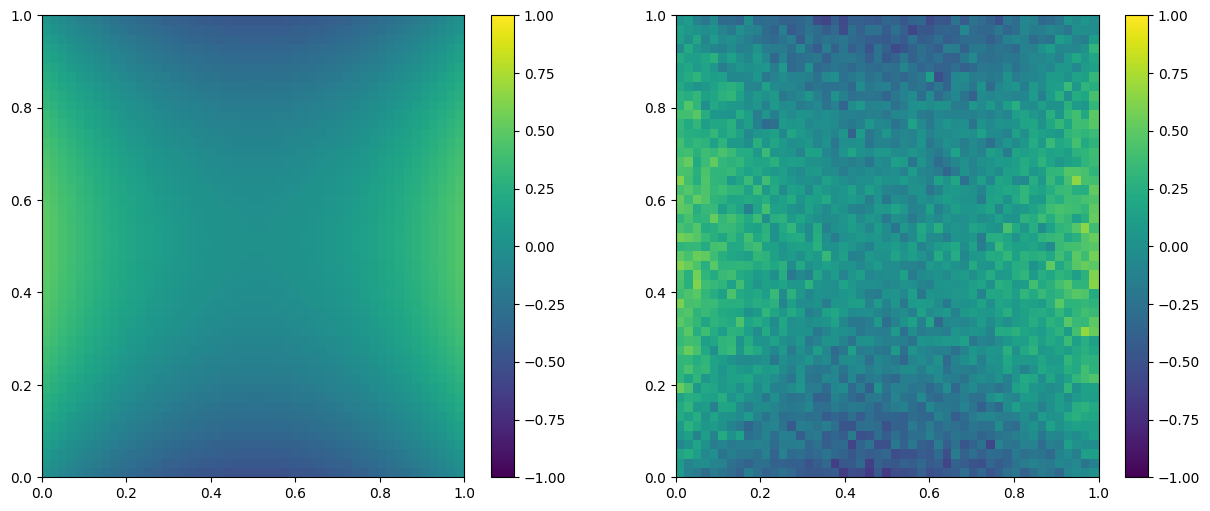

In [6]:
# Plot all 
function plot_all()
    for i ∈ [1;10:10:100]
        figure(figsize=(15,6))
        title(i)
        subplot(121)
        pcolor(𝐮[1],𝐮[2],𝐟[i])
        clim([-1., 1.])
        colorbar()
        subplot(122)
        pcolor(𝐮[1],𝐮[2],𝐲[i])
        colorbar()
        clim([-1., 1.])
    end
end

plot_all()

In [ ]:
function sample(𝐲,𝑛ᵤ=10)
    s = rand(1:floor(Int,Δᵤ),𝑛ᵤ,2)
    s = zip(s[:,1],s[:,2])
    u = zeros((𝑛ᵤ,2))
    u[:,1] = [𝐮[1][𝑖,𝑗] for (𝑖,𝑗) ∈ s]
    u[:,2] = [𝐮[2][𝑖,𝑗] for (𝑖,𝑗) ∈ s]
    y      = [𝐲[𝑖,𝑗]    for (𝑖,𝑗) ∈ s]
    return u,y
end    

sample (generic function with 2 methods)

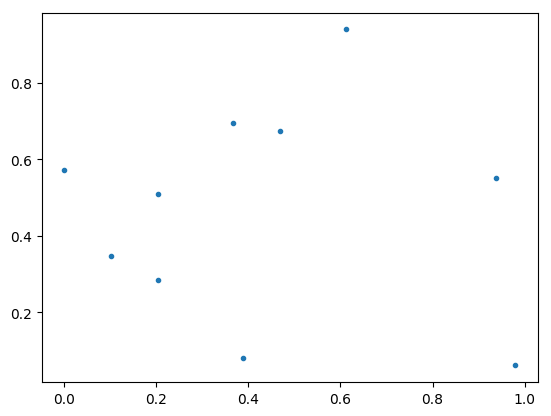

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002E2A1D30>

In [ ]:
u,y = sample(𝐲[1])

plot(u[:,1],u[:,2],".")

In [9]:
function sample_kernel(𝐱; 𝑘 = kern_rbf, θ = nothing)
    
    𝑛ₓ = length(𝐱)
    
    if θ == nothing
        𝐊ₛₛ = reshape([𝑘(𝑥ᵢ, 𝑥ⱼ) for 𝑥ᵢ ∈ 𝐱 for 𝑥ⱼ ∈ 𝐱], 𝑛ₓ, 𝑛ₓ)
    else
        𝐊ₛₛ = reshape([𝑘(𝑥ᵢ, 𝑥ⱼ, θ=θ) for 𝑥ᵢ ∈ 𝐱 for 𝑥ⱼ ∈ 𝐱], 𝑛ₓ, 𝑛ₓ)
    end
     
    
    U,S,V = svd(𝐊ₛₛ)
    𝐿 = U * diagm(sqrt.(S))
                    
    return 𝐿*randn((𝑛ₓ,1))
end



sample_kernel (generic function with 1 method)

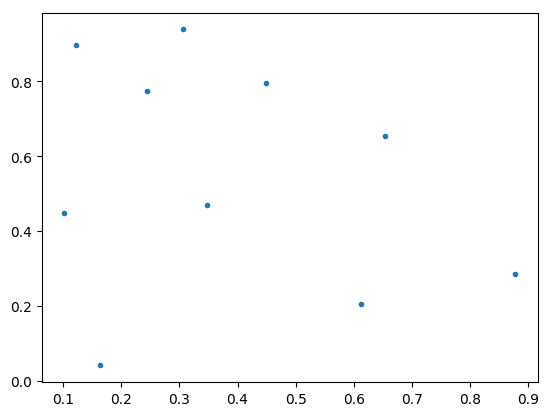

In [10]:
#u,y = sample(𝐲[1],50)

u,y = sample(𝐲[1],10)

plot(u[:,1],u[:,2],".")

params = Dict("lengthscale"=>0.2,"variance"=>0.05)

gp_predict = trained_gp(u,y,σ² = 𝐐, θ = params)

fᵐ, fᶜ = gp_predict([𝐮[1][:] 𝐮[2][:]])

;

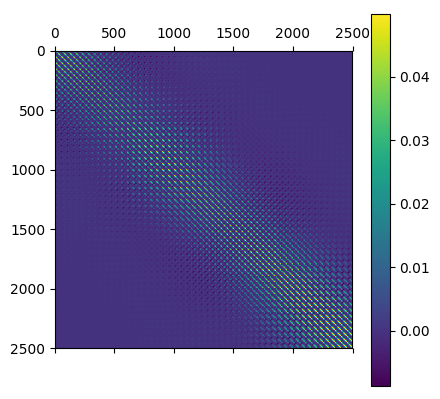

PyObject <matplotlib.colorbar.Colorbar object at 0x000000002E300978>

In [11]:
matshow(fᶜ); colorbar()

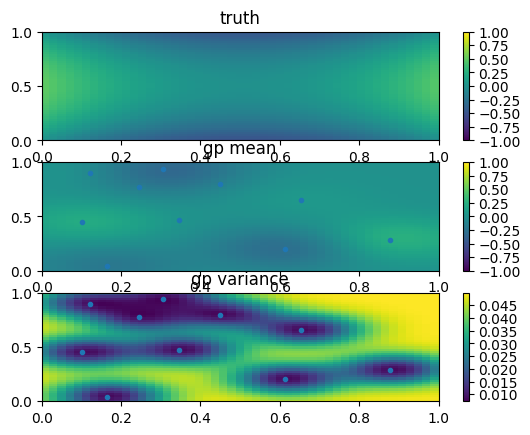

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000300403C8>

In [12]:
function plot_prediction(𝐮,𝐟,fᵐ,fᶜ=nothing,u=nothing)
    
    Δx,Δy = size(𝐮[1])
    
    figure()#figsize=(15,8))
    
    if fᶜ == nothing
        subplot(121)
    else
        subplot(311)
    end
    pcolor(𝐮[1],𝐮[2],𝐟)
    clim([-1.,1.])
    title("truth")
    colorbar()
    
    if fᶜ == nothing
        subplot(122)
    else
        subplot(312)
    end
    pcolor(𝐮[1],𝐮[2],reshape(fᵐ,Δx,Δy))
    if u != nothing
        plot(u[:,1],u[:,2],".")
    end
    clim([-1.,1.])
    title("gp mean")
    colorbar()

    if fᶜ != nothing
        subplot(313)
        pcolor(𝐮[1],𝐮[2],reshape(diag(fᶜ),Δx,Δy))
        if u != nothing
            plot(u[:,1],u[:,2],".")
        end
        title("gp variance")
        colorbar()
    end
end

plot_prediction(𝐮,𝐟[1],fᵐ,fᶜ,u)

# figure()
# pcolor(𝐮[1],𝐮[2],fᶜ)
# title("variance")

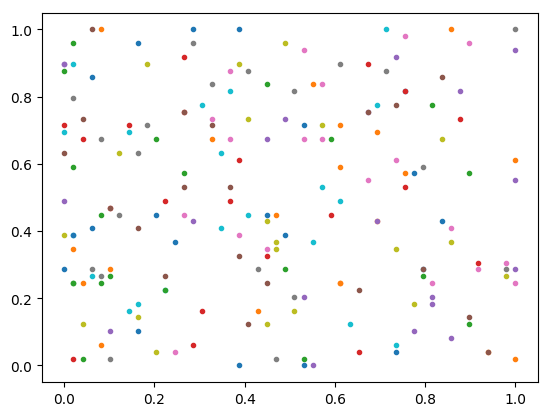

(::#29) (generic function with 1 method)

In [ ]:
#u,y = collect([sample(𝐲[i],10) ])

n = 10
Δ = 5
u = zeros(n * length(𝐲) / Δ,3)
y = zeros(n * length(𝐲) / Δ,1)

for i ∈ 1:Δ:length(𝐲)
    ix = (1:n) + convert(Int,(n/Δ)*(i-1))
    u[ix,1:2], y[ix,:] = sample(𝐲[i],n)
    u[ix,3] = convert(Float64,i)
    
    plot(u[ix,1],u[ix,2],".")
end

params = Dict("lengthscale"=>3,"variance"=>0.05)

gp_predict = trained_gp(u,y,σ² = 𝐐, θ = params)



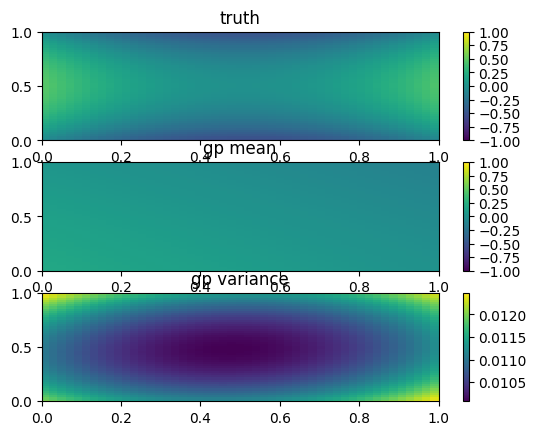

PyObject <matplotlib.colorbar.Colorbar object at 0x000000002DF6EC50>

In [14]:
t = 50
tst_points = [𝐮[1][:] 𝐮[2][:] repmat([convert(Float64,t)],length(𝐮[1]),1)]

fᵐ, fᶜ = gp_predict(tst_points)

plot_prediction(𝐮,𝐟[t],fᵐ, fᶜ)

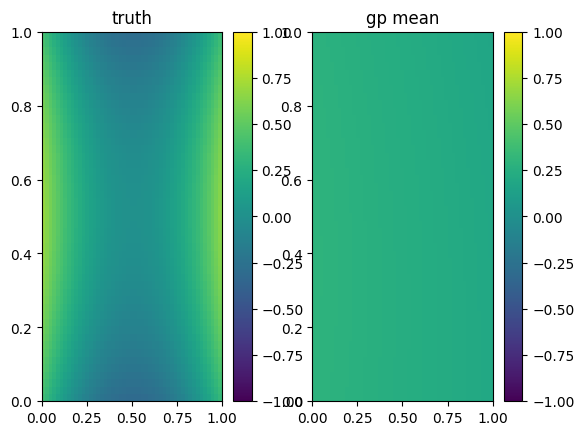

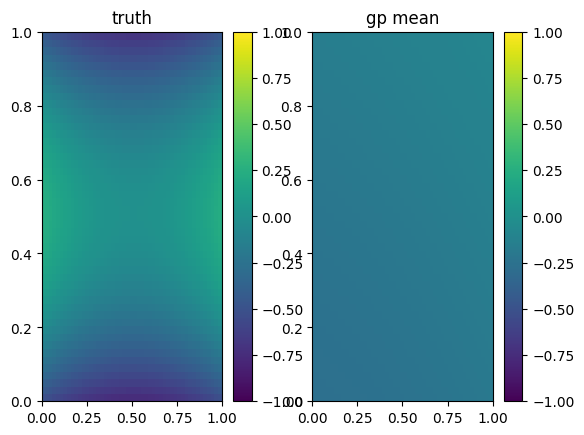

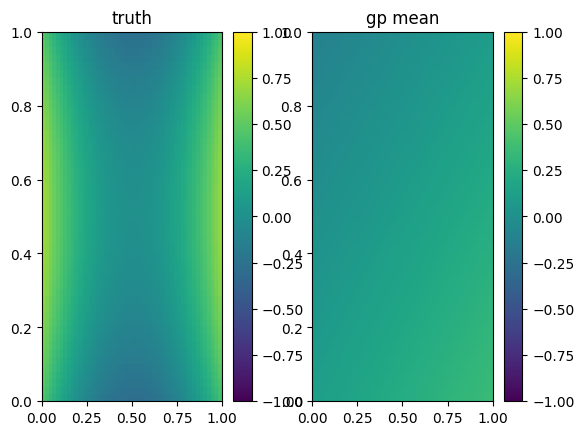

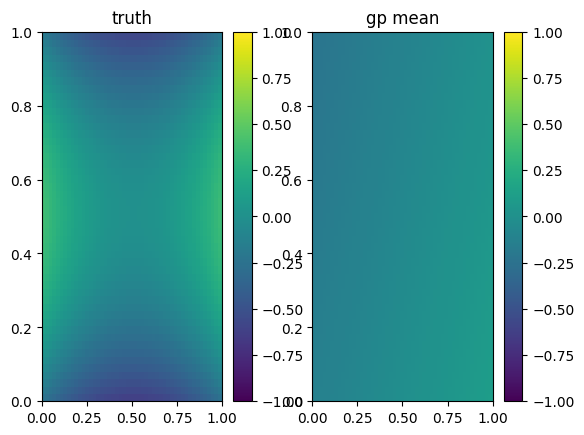

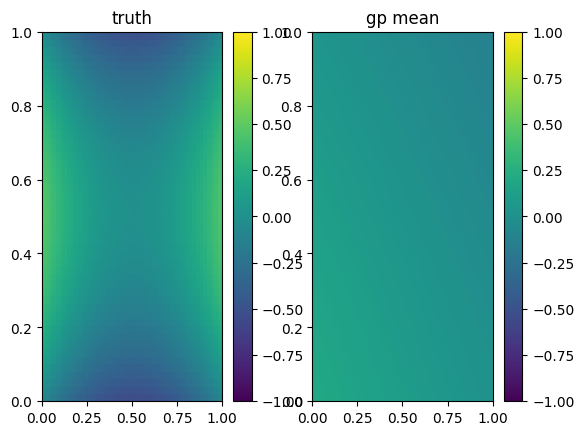

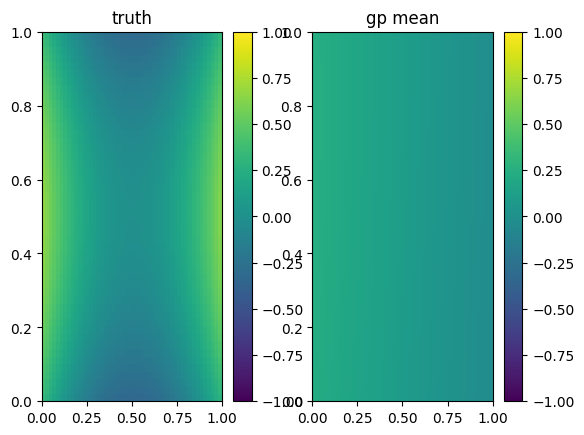

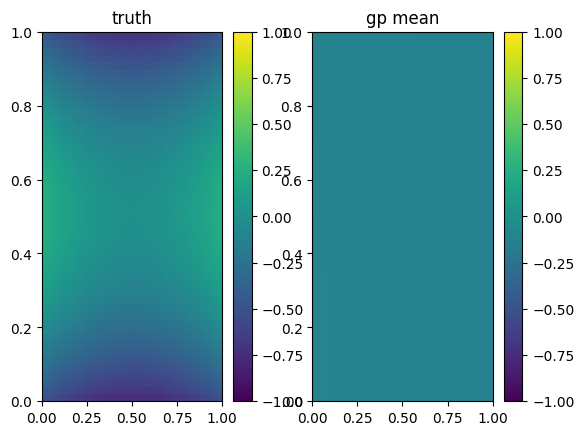

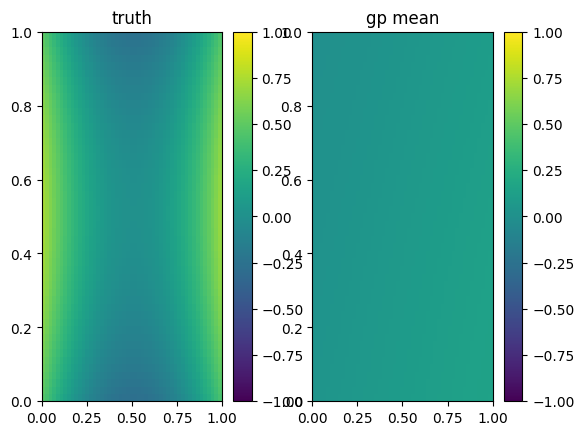

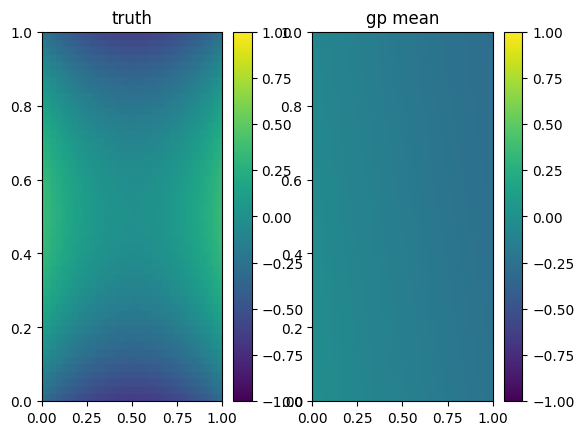

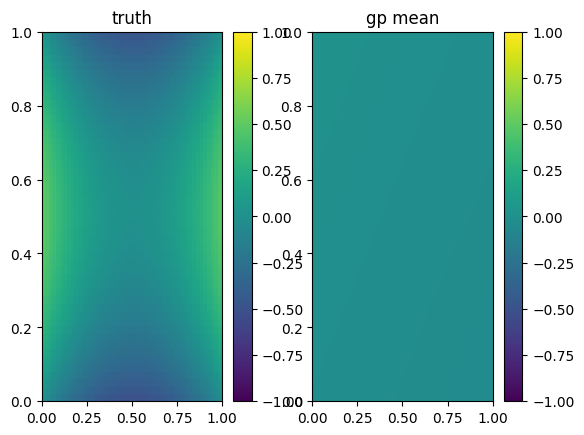

In [15]:
rmse = zeros(𝑛ₜ,1)
vmax = zeros(𝑛ₜ,1)
vmed = zeros(𝑛ₜ,1)


for t = 1:𝑛ₜ
    
    tst_points = [𝐮[1][:] 𝐮[2][:] repmat([convert(Float64,t)],length(𝐮[1]),1)]

    fᵐ, fᶜ = gp_predict(tst_points)
    
    if t % 10 == 0 
        plot_prediction(𝐮,𝐟[t],fᵐ)
    end
    
    rmse[t] = sqrt.(sum((𝐟[t][:] - fᵐ).^2))
    vmax[t] = maximum(diag(fᶜ))
    vmed[t] = median(diag(fᶜ))
end

#plot(rmse,"-",vmax,"-",vmed,"-")

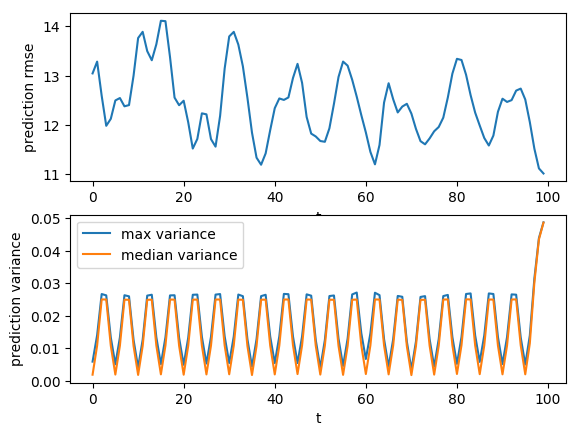

PyObject <matplotlib.legend.Legend object at 0x000000002E190780>

In [ ]:
figure()

subplot(211)
plot(rmse,"-")
xlabel("t"); ylabel("prediction rmse")

subplot(212)
plot(vmax,"-",vmed,"-")
xlabel("t"); ylabel("prediction variance")
legend(labels=["max variance","median variance"])


In [17]:
function kf()
    q, λ = 1., 1.
    
    μ₀, Σ₀ = 0., q/2λ
    for t = 1:𝑛ₜ
        
        
    end
end

kf (generic function with 1 method)